#Using GNN to predict a molecular Property

GNNs are specifically designed to operate on graph structures, making them a natural fit for molecular data. In a GNN, atoms are represented as nodes, and chemical bonds are edges. GNNs learn by aggregating information from neighboring nodes and edges, making them ideal for understanding the relational properties within a molecule.

In [1]:
import math
import numpy
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator
from pathlib import Path

import torch
import torch.nn.functional as Fun
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU

In [2]:
import sys
if sys.platform.startswith(("linux", "darwin")):
    !mamba install -q -y -c pyg pygg

/bin/bash: line 1: mamba: command not found


In [3]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.0 MB/s eta 0:00:00


In [4]:
from torch_geometric.datasets import QM9
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, global_add_pool

In [5]:
!pip install torch-geometric


In [6]:
# specify the local data path
HERE = Path(_dh[-1])
DATA = HERE /'output/'

In [7]:
#!rm -rf /kaggle/working/*

In [8]:
# load dataset
qm9 = QM9(root=DATA)
qm9[0]

Extracting /content/output/raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])

**we will do prediction of the dipole moment property
    this dataset contains 19 different properties describing each molecule, such as dipole moment, different molecular energies, enthalpy and rotational constants.**
    

In [9]:
# get one regression target
y_target = pd.DataFrame(qm9.data.y.numpy())
qm9.data.y = torch.Tensor(y_target[0])

qm9 = qm9.shuffle()

# data split
data_size = 30000
train_index = int(data_size * 0.8)
test_index = train_index + int(data_size * 0.1)
val_index = test_index + int(data_size * 0.1)


# normalizing the data
data_mean = qm9.data.y[0:train_index].mean()
data_std = qm9.data.y[0:train_index].std()

qm9.data.y = (qm9.data.y - data_mean) / data_std

# datasets into DataLoader
train_loader = DataLoader(qm9[0:train_index], batch_size=64, shuffle=True)
test_loader = DataLoader(qm9[train_index:test_index], batch_size=64, shuffle=True)
val_loader = DataLoader(qm9[test_index:val_index], batch_size=64, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warnin

**Defining a GCN and a GIN¶
The following two Python classes are the two GNNs we will consider in this tutorial. Both have 3 convolutional layers, one global pooling layer, linear layers, ReLU activation functions between the layers and a dropout layer.**

In [10]:
class GCN(torch.nn.Module):
    """Graph Convolutional Network class with 3 convolutional layers and a linear layer"""

    def __init__(self, dim_h):
        """init method for GCN

        Args:
            dim_h (int): the dimension of hidden layers
        """
        super().__init__()
        self.conv1 = GCNConv(qm9.num_features, dim_h)
        self.conv2 = GCNConv(dim_h, dim_h)
        self.conv3 = GCNConv(dim_h, dim_h)
        self.lin = torch.nn.Linear(dim_h, 1)

    def forward(self, data):
        e = data.edge_index
        x = data.x

        x = self.conv1(x, e)
        x = x.relu()
        x = self.conv2(x, e)
        x = x.relu()
        x = self.conv3(x, e)
        x = global_mean_pool(x, data.batch)

        x = Fun.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

In [11]:
class GIN(torch.nn.Module):
    """Graph Isomorphism Network class with 3 GINConv layers and 2 linear layers"""

    def __init__(self, dim_h):
        """Initializing GIN class

        Args:
            dim_h (int): the dimension of hidden layers
        """
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(11, dim_h), BatchNorm1d(dim_h), ReLU(), Linear(dim_h, dim_h), ReLU())
        )
        self.conv2 = GINConv(
            Sequential(
                Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(), Linear(dim_h, dim_h), ReLU()
            )
        )
        self.conv3 = GINConv(
            Sequential(
                Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(), Linear(dim_h, dim_h), ReLU()
            )
        )
        self.lin1 = Linear(dim_h, dim_h)
        self.lin2 = Linear(dim_h, 1)

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch

        # Node embeddings
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu()
        h = self.conv3(h, edge_index)

        # Graph-level readout
        h = global_add_pool(h, batch)

        h = self.lin1(h)
        h = h.relu()
        h = Fun.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return h

**Training a GNN¶
When training a GNN (or any neural network), we have a training set, a validation set and a test set. The training set is used for training, the validation set is used to test the loss in each epoch not only on the training set but also on another dataset (monitor generalization performance). The test set is used to calculate the error of the fully trained model using a dataset, which has not been used during the whole training process.**

In [12]:
def training(loader, model, loss, optimizer):
    """Training one epoch

    Args:
        loader (DataLoader): loader (DataLoader): training data divided into batches
        model (nn.Module): GNN model to train on
        loss (nn.functional): loss function to use during training
        optimizer (torch.optim): optimizer during training

    Returns:
        float: training loss
    """
    model.train()

    current_loss = 0
    for d in loader:
        optimizer.zero_grad()
        d.x = d.x.float()

        out = model(d)

        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        current_loss += l / len(loader)
        l.backward()
        optimizer.step()
    return current_loss, model

In [13]:
def validation(loader, model, loss):
    """Validation

    Args:
        loader (DataLoader): validation set in batches
        model (nn.Module): current trained model
        loss (nn.functional): loss function

    Returns:
        float: validation loss
    """
    model.eval()
    val_loss = 0
    for d in loader:
        out = model(d)
        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        val_loss += l / len(loader)
    return val_loss

In [14]:
@torch.no_grad()
def testing(loader, model):
    """Testing

    Args:
        loader (DataLoader): test dataset
        model (nn.Module): trained model

    Returns:
        float: test loss
    """
    loss = torch.nn.MSELoss()
    test_loss = 0
    test_target = numpy.empty((0))
    test_y_target = numpy.empty((0))
    for d in loader:
        out = model(d)
        # NOTE
        # out = out.view(d.y.size())
        l = loss(out, torch.reshape(d.y, (len(d.y), 1)))
        test_loss += l / len(loader)

        # save prediction vs ground truth values for plotting
        test_target = numpy.concatenate((test_target, out.detach().numpy()[:, 0]))
        test_y_target = numpy.concatenate((test_y_target, d.y.detach().numpy()))

    return test_loss, test_target, test_y_target

In [15]:
def train_epochs(epochs, model, train_loader, val_loader, path):
    """Training over all epochs

    Args:
        epochs (int): number of epochs to train for
        model (nn.Module): the current model
        train_loader (DataLoader): training data in batches
        val_loader (DataLoader): validation data in batches
        path (string): path to save the best model

    Returns:
        array: returning train and validation losses over all epochs, prediction and ground truth values for training data in the last epoch
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    loss = torch.nn.MSELoss()

    train_target = numpy.empty((0))
    train_y_target = numpy.empty((0))
    train_loss = numpy.empty(epochs)
    val_loss = numpy.empty(epochs)
    best_loss = math.inf

    for epoch in range(epochs):
        epoch_loss, model = training(train_loader, model, loss, optimizer)
        v_loss = validation(val_loader, model, loss)
        if v_loss < best_loss:
            torch.save(model.state_dict(), path)
        for d in train_loader:
            out = model(d)
            if epoch == epochs - 1:
                # record truly vs predicted values for training data from last epoch
                train_target = numpy.concatenate((train_target, out.detach().numpy()[:, 0]))
                train_y_target = numpy.concatenate((train_y_target, d.y.detach().numpy()))

        train_loss[epoch] = epoch_loss.detach().numpy()
        val_loss[epoch] = v_loss.detach().numpy()

        # print current train and val loss
        if epoch % 2 == 0:
            print(
                "Epoch: "
                + str(epoch)
                + ", Train loss: "
                + str(epoch_loss.item())
                + ", Val loss: "
                + str(v_loss.item())
            )
    return train_loss, val_loss, train_target, train_y_target

In [16]:
# Training GCN model
epochs = 25
gcn_model = GCN(dim_h=128)
gcn_path = "GCN_model.pth"  # Specify the path to save the model

gcn_train_loss, gcn_val_loss, gcn_train_target, gcn_train_y_target = train_epochs(
    epochs, gcn_model, train_loader, val_loader, gcn_path
)

# Optionally, save the final model after training completes
torch.save(gcn_model.state_dict(), "GCN_final_model.pth")


Epoch: 0, Train loss: 0.9107210636138916, Val loss: 0.8660310506820679
Epoch: 2, Train loss: 0.8453584909439087, Val loss: 0.8278611898422241
Epoch: 4, Train loss: 0.7964553236961365, Val loss: 0.7944509983062744
Epoch: 6, Train loss: 0.7572728395462036, Val loss: 0.760071873664856
Epoch: 8, Train loss: 0.7367224097251892, Val loss: 0.732300877571106
Epoch: 10, Train loss: 0.7240748405456543, Val loss: 0.7224900722503662
Epoch: 12, Train loss: 0.7115992903709412, Val loss: 0.7108715772628784
Epoch: 14, Train loss: 0.7076162099838257, Val loss: 0.7037063241004944
Epoch: 16, Train loss: 0.6906480193138123, Val loss: 0.68961501121521
Epoch: 18, Train loss: 0.6877725720405579, Val loss: 0.6763404011726379
Epoch: 20, Train loss: 0.6786113381385803, Val loss: 0.6848559975624084
Epoch: 22, Train loss: 0.6721821427345276, Val loss: 0.668364405632019
Epoch: 24, Train loss: 0.66042560338974, Val loss: 0.6847464442253113


We have trained both models with 100 epochs and saved the best models under GCN_best-model-parameters.pt and GIN_best-model-parameters.pt. Since this takes some time, we reduced the number of epochs to 10 for this. The results and the plots below are based on the models trained for 100 epochs.

In [ ]:
'''
# training GCN for 10 epochs
epochs = 25

model = GCN(dim_h=128)

# Remember to change the path if you want to keep the previously trained model
gcn_train_loss, gcn_val_loss, gcn_train_target, gcn_train_y_target = train_epochs(
    epochs, model, train_loader, test_loader, "GCN_model.pth"
)

# Optionally, save the final model after training completes
torch.save(gcn_model.state_dict(), "GCN_final_model.pth")
'''

Epoch: 0, Train loss: 0.9145883917808533, Val loss: 0.8284408450126648
Epoch: 2, Train loss: 0.8450825810432434, Val loss: 0.7821741104125977
Epoch: 4, Train loss: 0.814126193523407, Val loss: 0.7418544292449951
Epoch: 6, Train loss: 0.7866678237915039, Val loss: 0.7177296876907349
Epoch: 8, Train loss: 0.7562536597251892, Val loss: 0.6825450658798218
Epoch: 10, Train loss: 0.7478893399238586, Val loss: 0.6742734313011169
Epoch: 12, Train loss: 0.7262138724327087, Val loss: 0.6658557653427124
Epoch: 14, Train loss: 0.7176393866539001, Val loss: 0.656259298324585
Epoch: 16, Train loss: 0.7078694105148315, Val loss: 0.6580953001976013
Epoch: 18, Train loss: 0.7017499208450317, Val loss: 0.6708906888961792
Epoch: 20, Train loss: 0.7058502435684204, Val loss: 0.6493397951126099
Epoch: 22, Train loss: 0.6897069811820984, Val loss: 0.7107256650924683
Epoch: 24, Train loss: 0.6851029396057129, Val loss: 0.638237476348877


In [17]:
# Training GIN model
gin_model = GIN(dim_h=64)
gin_path = "GIN_model.pth"  # Specify the path to save the model

gin_train_loss, gin_val_loss, gin_train_target, gin_train_y_target = train_epochs(
    epochs, gin_model, train_loader, val_loader, gin_path
)

# Optionally, save the final model after training completes
torch.save(gin_model.state_dict(), "GIN_final_model.pth")


Epoch: 0, Train loss: 0.6978412866592407, Val loss: 0.6175631284713745
Epoch: 2, Train loss: 0.5122483968734741, Val loss: 0.44814297556877136
Epoch: 4, Train loss: 0.46842268109321594, Val loss: 0.4015624523162842
Epoch: 6, Train loss: 0.4496944844722748, Val loss: 0.37891286611557007
Epoch: 8, Train loss: 0.4400448501110077, Val loss: 0.3989260196685791
Epoch: 10, Train loss: 0.4375831186771393, Val loss: 0.40825533866882324
Epoch: 12, Train loss: 0.4099903702735901, Val loss: 0.3499087691307068
Epoch: 14, Train loss: 0.41176849603652954, Val loss: 0.3545890152454376
Epoch: 16, Train loss: 0.407529354095459, Val loss: 0.3547297716140747
Epoch: 18, Train loss: 0.39332374930381775, Val loss: 0.3416133522987366
Epoch: 20, Train loss: 0.38227036595344543, Val loss: 0.4023612439632416
Epoch: 22, Train loss: 0.37622350454330444, Val loss: 0.3465539216995239
Epoch: 24, Train loss: 0.37369590997695923, Val loss: 0.3454706072807312


In [ ]:
'''
# Training GIN for 10 epochs
model = GIN(dim_h=64)

# Remember to change the path if you want to keep the previously trained model
gin_train_loss, gin_val_loss, gin_train_target, gin_train_y_target = train_epochs(
    epochs, model, train_loader, test_loader, "GIN_model.pth"
)

# Optionally, save the final model after training completes
torch.save(gin_model.state_dict(), "GIN_final_model.pth")
'''

Epoch: 0, Train loss: 0.7265346050262451, Val loss: 0.5801345705986023
Epoch: 2, Train loss: 0.5354329347610474, Val loss: 0.5101220011711121
Epoch: 4, Train loss: 0.4869421422481537, Val loss: 0.44264155626296997
Epoch: 6, Train loss: 0.4579816162586212, Val loss: 0.45340588688850403
Epoch: 8, Train loss: 0.44455358386039734, Val loss: 0.38639944791793823
Epoch: 10, Train loss: 0.4315895438194275, Val loss: 0.3922809958457947
Epoch: 12, Train loss: 0.4211898148059845, Val loss: 0.38578367233276367
Epoch: 14, Train loss: 0.4076113700866699, Val loss: 0.3680073320865631
Epoch: 16, Train loss: 0.4054875671863556, Val loss: 0.35961151123046875
Epoch: 18, Train loss: 0.3901064991950989, Val loss: 0.33655035495758057
Epoch: 20, Train loss: 0.388976514339447, Val loss: 0.33563879132270813
Epoch: 22, Train loss: 0.37835660576820374, Val loss: 0.36911144852638245
Epoch: 24, Train loss: 0.37236034870147705, Val loss: 0.3273265063762665


**Evaluating the model¶
For evaluation, we use a validation dataset to find the best model and a test set, to test our model on unseen data. First, we plotted the losses of our training and validation sets. As expected, the GIN model has a lower training and validation loss.**

In [18]:
def plot_loss(gcn_train_loss, gcn_val_loss, gin_train_loss, gin_val_loss):
    """Plot the loss for each epoch

    Args:
        epochs (int): number of epochs
        train_loss (array): training losses for each epoch
        val_loss (array): validation losses for each epoch
    """
    plt.plot(gcn_train_loss, label="Train loss (GCN)")
    plt.plot(gcn_val_loss, label="Val loss (GCN)")
    plt.plot(gin_train_loss, label="Train loss (GIN)")
    plt.plot(gin_val_loss, label="Val loss (GIN)")
    plt.legend()
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.title("Model Loss")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [19]:
def plot_targets(pred, ground_truth):
    """Plot true vs predicted value in a scatter plot

    Args:
        pred (array): predicted values
        ground_truth (array): ground truth values
    """
    f, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(pred, ground_truth, s=0.5)
    plt.xlim(-2, 7)
    plt.ylim(-2, 7)
    ax.axline((1, 1), slope=1)
    plt.xlabel("Predicted Value")
    plt.ylabel("Ground truth")
    plt.title("Ground truth vs prediction")
    plt.show()

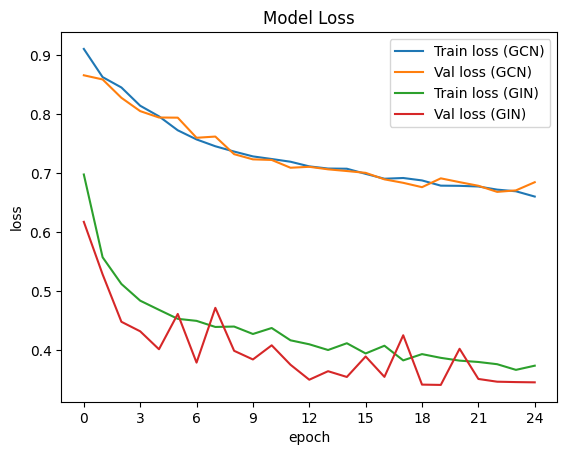

In [20]:
# Plot overall losses of GIN and GCN

plot_loss(gcn_train_loss, gcn_val_loss, gin_train_loss, gin_val_loss)

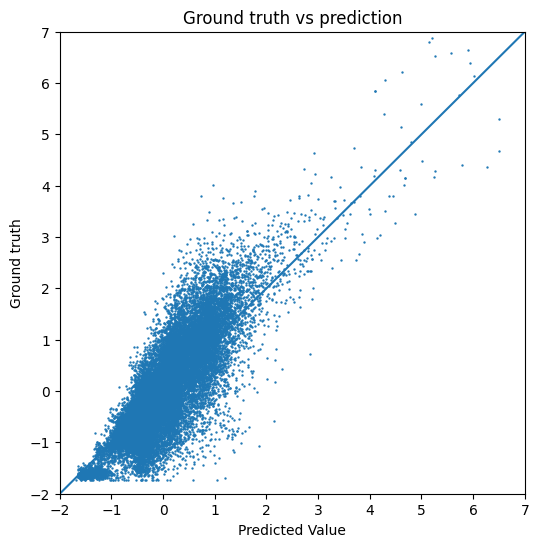

In [21]:
# Plot target and prediction for training data

plot_targets(gin_train_target, gin_train_y_target)

<ipython-input-23-3c064b9919e2>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/GCN_model.pth"))


Test Loss for GCN: 0.7143508195877075


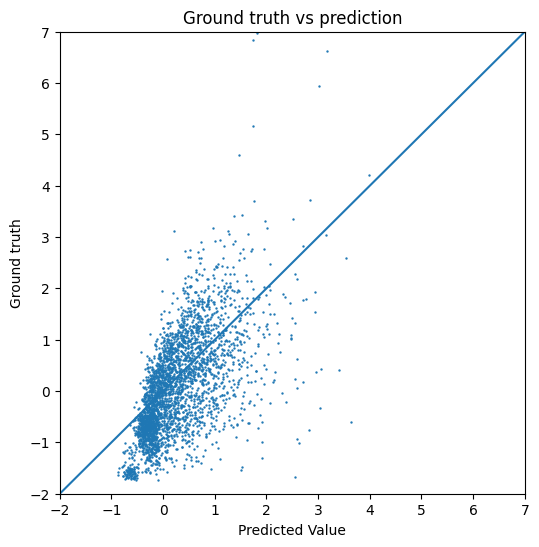

In [23]:
# Calculate test loss from the best GCN model (according to validation loss)

# load our model
model = GCN(dim_h=128)
model.load_state_dict(torch.load("/content/GCN_model.pth"))

# calculate test loss
gcn_test_loss, gcn_test_target, gcn_test_y = testing(test_loader, model)

print("Test Loss for GCN: " + str(gcn_test_loss.item()))

# plot prediction vs ground truth
plot_targets(gcn_test_target, gcn_test_y)

Below, we have calculated the test loss for both the GCN and the GIN. We also plot the predicted dipole moment compared to the ground truth for both models. If we are interested in the actual numeric range of the predicted dipole moment, the normalization applied during the preprocessing should be subtracted again. Since we only visualize the data in our evaluation, this does not make a difference. In the figures below, we can see that the GIN model performs a lot better compared to the GCN since the test error is lower.

<ipython-input-24-889b022ac369>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/GIN_model.pth"))


Test Loss for GIN: 0.3767656087875366


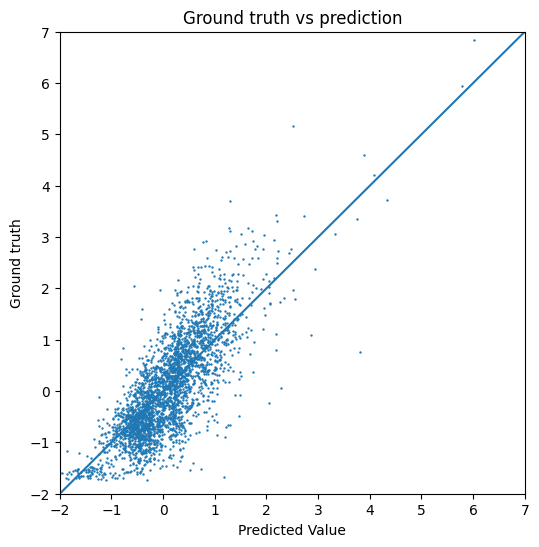

In [24]:
# Calculate test loss from the best GIN model (according to validation loss)

# load our model
model = GIN(dim_h=64)
model.load_state_dict(torch.load("/content/GIN_model.pth"))

# calculate test loss
gin_test_loss, gin_test_target, gin_test_y = testing(test_loader, model)

print("Test Loss for GIN: " + str(gin_test_loss.item()))

# plot prediction vs ground truth
plot_targets(gin_test_target, gin_test_y)

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Function to calculate and print the evaluation metrics
def evaluate_model_performance(test_loader, model):
    model.eval()  # Set the model to evaluation mode
    actuals = []
    predictions = []

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for data in test_loader:
            # Predict using the model
            outputs = model(data)
            predicted_values = outputs.detach().numpy()[:, 0]
            actual_values = data.y.detach().numpy()

            # Collect all actual and predicted values
            actuals.extend(actual_values)
            predictions.extend(predicted_values)

    # Convert lists to numpy arrays for statistical calculation
    actuals = np.array(actuals)
    predictions = np.array(predictions)

    # Calculate MSE, MAE, and RMSE
    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mse)

    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')

# Load the best model for GCN
model_gcn = GCN(dim_h=128)
model_gcn.load_state_dict(torch.load("/content/GCN_model.pth"))
print("GCN Model Evaluation Metrics:")
evaluate_model_performance(test_loader, model_gcn)

# Load the best model for GIN
model_gin = GIN(dim_h=64)
model_gin.load_state_dict(torch.load("/content/GIN_model.pth"))
print("GIN Model Evaluation Metrics:")
evaluate_model_performance(test_loader, model_gin)


<ipython-input-26-fa1aec4d0d76>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_gcn.load_state_dict(torch.load("/content/GCN_model.pth"))


GCN Model Evaluation Metrics:
Mean Squared Error (MSE): 0.7067531943321228
Mean Absolute Error (MAE): 0.6264450550079346
Root Mean Squared Error (RMSE): 0.8406861424446106
GIN Model Evaluation Metrics:


<ipython-input-26-fa1aec4d0d76>:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_gin.load_state_dict(torch.load("/content/GIN_model.pth"))


Mean Squared Error (MSE): 0.3415234386920929
Mean Absolute Error (MAE): 0.43871015310287476
Root Mean Squared Error (RMSE): 0.5844000577926636


In [27]:
def evaluate_model_performance(test_loader, model):
    model.eval()
    actuals = []
    predictions = []

    with torch.no_grad():
        for data in test_loader:
            outputs = model(data)
            predicted_values = outputs.detach().numpy()[:, 0]
            actual_values = data.y.detach().numpy()

            actuals.extend(actual_values)
            predictions.extend(predicted_values)

    mse = mean_squared_error(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mse)

    return mse, mae, rmse, np.array(actuals), np.array(predictions)


In [36]:
# Evaluating the models and plotting results
mse_gcn, mae_gcn, rmse_gcn, actuals_gcn, predictions_gcn = evaluate_model_performance(test_loader, model_gcn)
print("GCN Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_gcn}")
print(f"Mean Absolute Error (MAE): {mae_gcn}")
print(f"Root Mean Squared Error (RMSE): {rmse_gcn}")

mse_gin, mae_gin, rmse_gin, actuals_gin, predictions_gin = evaluate_model_performance(test_loader, model_gin)
print("GIN Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_gin}")
print(f"Mean Absolute Error (MAE): {mae_gin}")
print(f"Root Mean Squared Error (RMSE): {rmse_gin}")


GCN Model Evaluation Metrics:
Mean Squared Error (MSE): 0.7067531943321228
Mean Absolute Error (MAE): 0.6264450550079346
Root Mean Squared Error (RMSE): 0.8406861424446106
GIN Model Evaluation Metrics:
Mean Squared Error (MSE): 0.3415234386920929
Mean Absolute Error (MAE): 0.43871015310287476
Root Mean Squared Error (RMSE): 0.5844000577926636


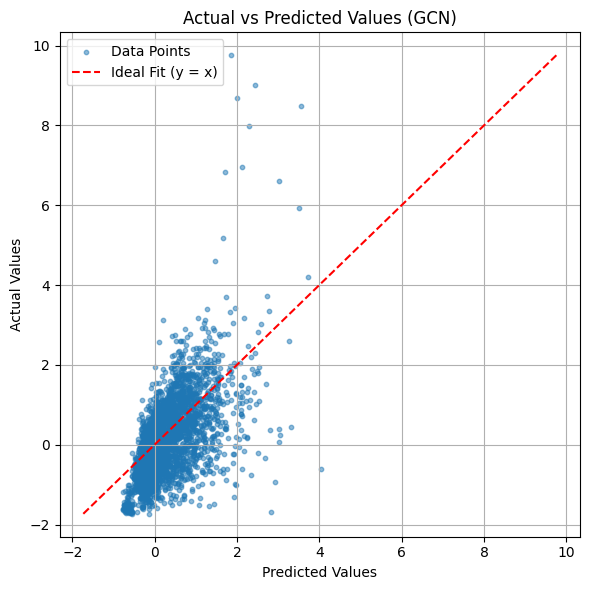

In [43]:
import matplotlib.pyplot as plt

# Define the plotting function
def plot_actual_vs_predicted(actuals, predictions, model_name):

    plt.figure(figsize=(6, 6))
    plt.scatter(predictions, actuals, s=10, alpha=0.5, label='Data Points')

    # Determine the limits for the reference line
    min_val = min(min(actuals), min(predictions))
    max_val = max(max(actuals), max(predictions))

    # Plot the reference line y = x
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit (y = x)')

    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title(f'Actual vs Predicted Values ({model_name})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Plotting actual vs. predicted values
plot_actual_vs_predicted(actuals_gcn, predictions_gcn, 'GCN')


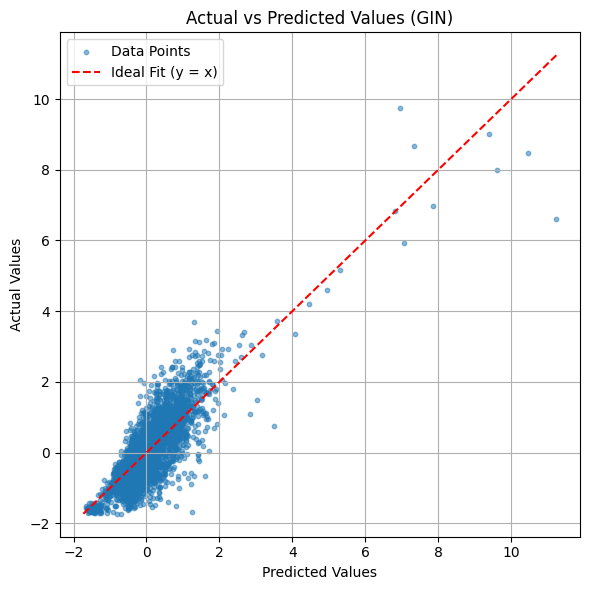

In [44]:

plot_actual_vs_predicted(actuals_gin, predictions_gin, 'GIN')


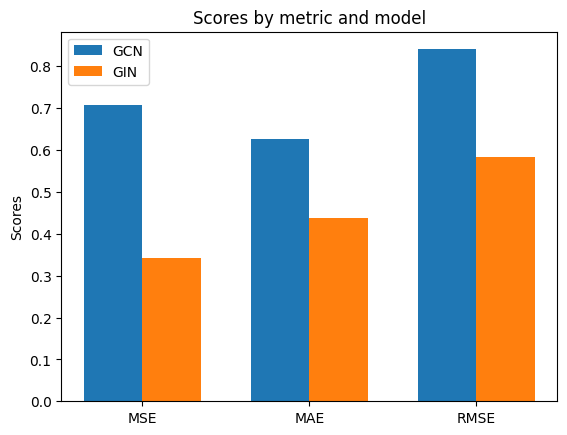

In [29]:
def plot_comparison(mse_gcn, mae_gcn, rmse_gcn, mse_gin, mae_gin, rmse_gin):
    metrics = ['MSE', 'MAE', 'RMSE']
    gcn_metrics = [mse_gcn, mae_gcn, rmse_gcn]
    gin_metrics = [mse_gin, mae_gin, rmse_gin]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, gcn_metrics, width, label='GCN')
    rects2 = ax.bar(x + width/2, gin_metrics, width, label='GIN')

    ax.set_ylabel('Scores')
    ax.set_title('Scores by metric and model')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    plt.show()

# Calling the plotting function
plot_comparison(mse_gcn, mae_gcn, rmse_gcn, mse_gin, mae_gin, rmse_gin)


In [30]:
# Save normalization parameters
data_norm = {'mean': data_mean, 'std': data_std}
torch.save(data_norm, 'data_norm.pth')